In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

# train data loader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
filename1 = '/content/drive/MyDrive/LSTM DATA/TFF.csv'
filename2 = '/content/drive/MyDrive/LSTM DATA/dataF.csv'

TF = pd.read_csv(filename1)
TF = TF.to_numpy()
data1 = pd.read_csv(filename2)
data = data1.loc[86434:,'close_1':'volume_1']
data = data.to_numpy()
dnumber_idx = 156433

class traindata:
    def start(self, seq_len, data, data_len , c_num ):
      end = data_len - seq_len + 1
      empty = np.zeros((data_len - seq_len + 1, seq_len, c_num))
      data[data>1] = 1
      data[data<-1] = -1
      for f in range(end):
        for i in range(seq_len):
          val = data[i+f,:]
          empty[f,i,:] = val
      return empty

train = traindata()
td = train.start(seq_len = 40, data = data, data_len = 70000, c_num = 4)
td = np.round(td,3)

seq_len = 40
data_len =70000
print(td.shape)
ff = data1.loc[seq_len - 1:data_len -1,:]
ff = ff['close'].values
print(ff.shape)
np.save('/content/drive/MyDrive/LSTM DATA/train_close',ff)

np.save('/content/drive/MyDrive/LSTM DATA/train_lstm', td)


(69961, 40, 4)
(69961,)


# one_hot ytrain

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np


filename1 = '/content/drive/MyDrive/LSTM DATA/TFF.csv'
filename2 = '/content/drive/MyDrive/original data/dataO.csv'

TF = pd.read_csv(filename1)
TF = TF.loc[86434:]
TF = TF.to_numpy()
data = pd.read_csv(filename1)
dnumber = 156433

class one_hot_ytrain:
  def start(self,data,data_len,seq_len):
    data = data[:,1]
    data = data*100
    data = np.round(data,1)
    empty = np.zeros((data_len - seq_len + 1, 1))
    for i in range(seq_len - 1 ,data_len):
      if data[i] > 10:
        data[i] = 1
      else :
        data[i] = 0
    data = data[seq_len -1 : data_len]
    print(data)
    print(data.shape)
    return data

y_train = one_hot_ytrain()
y_train = y_train.start(data = TF,data_len=70000, seq_len=40)
print(y_train.shape)
print(y_train[-20:])
# y_train = pd.DataFrame(y_train)
# y_train.to_csv('TF_lstm.csv')
# files.download('TF_lstm.csv')
np.save('/content/drive/MyDrive/LSTM DATA/TF_lstm', y_train)

# for i in range(10):
#   print(y_train[i,:])
# 39 ~ 99번 까지의 답을 구함 
# data 의 결과가 같음  / data_original 필요 / data_len = 실제 길이
#data_len = seq_len +1 = 처리하고 나온 데이터

[1. 0. 0. ... 0. 0. 1.]
(69961,)
(69961,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]


# lstm_model with valid

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
#data_load
train_lstm = np.load('/content/drive/MyDrive/BIG DATA/train_lstm.npy')
print(train_lstm.shape)
TF_lstm = np.load('/content/drive/MyDrive/BIG DATA/TF_lstm.npy')
print(TF_lstm.shape)
TFw = np.load('/content/drive/MyDrive/BIG DATA/TFw.npy')



gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)
train = torch.FloatTensor(train_lstm,requires_grad=True).to(gpu)
TF = torch.FloatTensor(TF_lstm).to(gpu)
TFw = torch.FloatTensor(TFw).to(gpu)

class com :
  def tf(self,name):
    label = 'change_' + name
    turn = torch.FloatTensor(data[label].values)
    turn1 = turn.view(100000,1)
    return turn1

#model sequence
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, 1, dropout=dropout, batch_first=True, bidirectional=bidirectional, num_layers = 5).to(gpu)
        self.softmax = nn.Softmax(dim=-1).to(gpu)
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input.to(gpu)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        softmax = self.softmax(rnn_output).to(gpu)
        return softmax



model = SingleRNN(input_size=16,hidden_size = 51, dropout = 0.2, bidirectional= False)
output1 = model(train)
optimizer = optim.Adam(model.parameters(), lr=0.01)

best_model_wts = model.state_dict()
best_acc = 0
best_epoch = 0

l_array = []
a_array = []
for epoch in range(5000):
  for phase in ['trian','valid']:
    if phase == 'train'
      output = model(train)
      loss = (torch.abs((output - TF)) * TFw).mean()
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    if phase =='valid':
      pred = model(valid)
      accuracy = criterion.forward(output,TF)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if accuracy > best_acc:
        best_model_wts = model.state_dict()
        best_ephoch = epoch
      if (epoch+1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy)

model_save_name = 'classifierL.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(best_model_wts, path)



SyntaxError: ignored

# make weight

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
TF_lstm = np.load('/content/drive/MyDrive/BIG DATA/TF_lstm.npy')
print(TF_lstm.shape)
TF_lstm = torch.FloatTensor(TF_lstm)
print(TF_lstm)
class makew:
  def start(self,label):
    empty = torch.zeros(49961,51)
    shape = label.shape
    batch = shape[0]
    dimension = shape[1]
        
    for i in range(batch):
      lb = label[i,:]
      f1i = 0
      for f in range(dimension):
        if lb[f] == 1:
          f1i = f
        for d in range(dimension):
          weight = abs(f1i - d) + 1
          empty[i,d] = weight
      if (i+1)%1000 ==0:
        print(i)
    return empty

weightTF = makew()
TFw = weightTF.start(label = TF_lstm)
TFw = TFw.numpy()
np.save('/content/drive/MyDrive/BIG DATA/TFw', TFw)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
TF_lstm = np.load('/content/drive/MyDrive/BIG DATA/TFw.npy')
print(TF_lstm.shape)
print(TF_lstm)

# new loss function with valid model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F

#data_load
#(9961, 40, 16)
#(9961, 51)
train_lstm = np.load('/content/drive/MyDrive/BIG DATA/train_lstm.npy')
print(train_lstm.shape)
TF_lstm = np.load('/content/drive/MyDrive/BIG DATA/TF_lstm.npy')
print(TF_lstm.shape)
TFw = np.load('/content/drive/MyDrive/BIG DATA/TFw.npy')

gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)
train1 = torch.FloatTensor(train_lstm)
train = train1[0:40000,30:,:].to(gpu)
trainv = train1[40000:,30:,:].to(gpu)
TF1 = torch.LongTensor(TF_lstm)
TF = TF1[0:40000].to(gpu)
TFv = TF1[40000:].to(gpu)
# TFw1 = torch.FloatTensor(TFw)
# TFw = TFw1[0:40000,:]
# TFwv = TFw1[40000:,:]
#model sequence
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.softmax = nn.Softmax(dim=-1)
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        softmax = self.softmax(rnn_output)
        return softmax


      


model = SingleRNN(input_size=16,hidden_size = 1, dropout = 0, bidirectional= False).to(gpu)
output1 = model(train)
# modelv = SingleRNN(input_size=16,hidden_size = 51, dropout = 0, bidirectional= False)

optimizer = optim.Adam(model.parameters(), lr=0.01)
best_model_wts = model.state_dict() 
best_acc = 0
best_epoch = 0
criterion = nn.CrossEntropyLoss()
l_array = []
a_array = []
for epoch in range(1000):
  for i in range(2):
    if i == 0:
      output = model(train)
      # loss = (torch.abs((output - TF))).mean()
      loss = criterion(output, TF)
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass
    
    if i == 1:
      pred = model(trainv)
      accuracy = criterion(pred,TFv)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if best_acc > accuracy:
        best_model_wts = model.state_dict()
        best_acc = accuracy
        best_ephoch = epoch
      if (epoch+1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy))
    else:
      pass
print(best_acc)
print(best_ephoch)

plt.plot(l_array, 'r')
plt.plot(a_array,'b')
plt.show()
model_save_name = 'classifierL.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)


(49961, 40, 16)
(49961,)
cuda


RuntimeError: ignored

# back test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.softmax = nn.Softmax(dim=-1)
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input.to(gpu)
        output = torch.unsqueeze(output,dim=0)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        softmax = self.softmax(rnn_output)
        return softmax
train_lstm = np.load('/content/drive/MyDrive/BIG DATA/train_lstm.npy')
print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/classifierL.pt'
model = SingleRNN(input_size=16,hidden_size = 16, dropout = 0, bidirectional= False).to(gpu)
model.load_state_dict(torch.load(model_wts))
train1 = torch.FloatTensor(train_lstm).to(gpu)
target = model(train1[9200,:,:])
print(target)

cuda
(49961, 40, 16)
tensor([[0.2568, 0.2568, 0.0348, 0.0348, 0.0347, 0.0347, 0.0347, 0.0347, 0.0347,
         0.0347, 0.0347, 0.0347, 0.0347, 0.0347, 0.0347, 0.0347]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)


# 새 섹션

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
#shape(batch, seq_len , dim_len) (batch, dim_len)
class backtest:
    model = MultiArchitecture()
    model.load_state_dict(torch.load(model_wts)) #
    s , l = 0,0
    i = start #
    lb = []
    lopen = 0
    lclose = 0
    ls = []
    sb = []
    sopen = 0
    sclose = 0
    ss = []
    for i in range(start, end + 1):
      x = data[i,:,:]
      target = model(x)
      price = close[i]
      lline = int(target[0,])


# data index valid

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
# train_lstm = np.load('/content/drive/MyDrive/BIG DATA/train_lstm.npy')
# print(train_lstm[0:6,39,:])
TF_lstm = np.load('/content/drive/MyDrive/BIG DATA/TF_lstm.npy')
print(TF_lstm[0:100])
# TFw = np.load('/content/drive/MyDrive/BIG DATA/TFw.npy')
# print(TFw[0:4,:])
# train_close = np.load('/content/drive/MyDrive/BIG DATA/train_close.npy')
# print(train_close[0:6])

# 정리

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F

#data_load
#(9961, 40, 16)
#(9961, 51)
train_lstm = np.load('/content/drive/MyDrive/LSTM DATA/past_volume change/train_lstm.npy')
print(train_lstm.shape)
TF_lstm = np.load('/content/drive/MyDrive/LSTM DATA/past_volume change/TF_lstm.npy')
print(TF_lstm.shape)

gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)
train1 = torch.FloatTensor(train_lstm)

train = train1[0:40000,20:,0].to(gpu)
trainv = train1[40000:,20:,0].to(gpu)

TF1 = torch.IntTensor(TF_lstm)
TF = TF1[0:40000]
TF = TF.type(torch.FloatTensor).to(gpu)
# TF = torch.squeeze(TF,dim=0).to(gpu)
TFv = TF1[40000:]

TFv = TFv.type(torch.FloatTensor).to(gpu)
# TFv = torch.squeeze(TFv).to(gpu)
# TFw1 = torch.FloatTensor(TFw)
# TFw = TFw1[0:40000,:]
# TFwv = TFw1[40000:,:]
#model sequence
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(5,1)
        self.softmax = nn.Softmax(dim=-1)
        
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input
        output = torch.unsqueeze(output,dim= -1)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        softmax = torch.sigmoid(fc)
        softmax = torch.squeeze(softmax, dim = 1)
        
        return softmax


      


model = SingleRNN(input_size=1,hidden_size = 5, dropout = 0.2, bidirectional= False).to(gpu)
output1 = model(train)
# modelv = SingleRNN(input_size=16,hidden_size = 51, dropout = 0, bidirectional= False)

optimizer = optim.Adam(model.parameters(), lr=0.01)
best_model_wts = model.state_dict() 
best_acc = 0
best_epoch = 0
criterion = nn.MSELoss()
l_array = []
a_array = []
for epoch in range(2000):
  for i in range(2):
    if i == 0:
      output = model(train)
      # loss = (torch.abs((output - TF))).mean()
      loss = criterion(output, TF)
      
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass
    
    if i == 1:
      pred = model(trainv)
      accuracy = criterion(pred,TFv)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if best_acc > accuracy:
        best_model_wts = model.state_dict()
        best_acc = accuracy
        best_ephoch = epoch
      if (epoch+1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy))
    else:
      pass

plt.plot(l_array, 'r')
plt.plot(a_array,'b')
plt.show()
model_save_name = 'classifierLSTM.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)


# 검증

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size,1)
        self.softmax = nn.Softmax(dim=-1)
        
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output2 = input
        output1 = torch.unsqueeze(output2, dim= 0)
        output1 = torch.unsqueeze(output1, dim = -1)
        rnn_output, _ = self.rnn(output1)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        softmax = torch.sigmoid(fc)
        softmax = torch.squeeze(softmax, dim = 1)
        
        return softmax
train_lstm = np.load('/content/drive/MyDrive/LSTM DATA/past_volume change/train_lstm.npy')
# print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/classifierLSTM.pt'
model = SingleRNN(input_size=1,hidden_size = 5, dropout = 0, bidirectional= False).to(gpu)
model.load_state_dict(torch.load(model_wts))
train1 = torch.FloatTensor(train_lstm).to(gpu)
# print(train1.shape)
target = model(train1[995,20:,0])
print(target)
l = []
all = []
for i in range(0,40000):
  target = model(train1[i,20:,0])
  all.append(target.item())
  if target >0.5:
    l.append(target.item())

print(l)
print(sum(all)/len(all))


cuda
tensor([0.3332], device='cuda:0', grad_fn=<SqueezeBackward1>)
[0.5178651213645935, 0.5249249339103699, 0.5026972889900208, 0.5005924105644226, 0.5238040089607239, 0.5316691398620605, 0.5086472630500793, 0.5274525284767151, 0.5062114596366882, 0.5578371286392212, 0.57901531457901, 0.5975511074066162, 0.6065275073051453, 0.5649980306625366, 0.5011890530586243, 0.5317463278770447, 0.5427222847938538, 0.5335729122161865, 0.5523673295974731, 0.575163722038269, 0.530651867389679, 0.5113027691841125, 0.5212799906730652, 0.535923421382904, 0.5437021851539612, 0.5458093881607056, 0.5631892681121826, 0.6083049774169922, 0.5005756616592407, 0.505474328994751, 0.5995793342590332, 0.5186342597007751, 0.513103187084198, 0.5786542892456055, 0.504291832447052, 0.5697670578956604, 0.5126372575759888, 0.5005491971969604, 0.5014968514442444, 0.5835168957710266, 0.5519956946372986, 0.6091713309288025, 0.5217649936676025, 0.5238515734672546, 0.5252776145935059, 0.5667930245399475, 0.5731973052024841, 

# 백테스트

cuda
0.15445101078105256
-0.1384962817479669
0.2375
[24143.21, 24106.84, 24139.32, 24115.02, 24145.99, 24077.77, 24082.53, 24028.26, 24059.6, 24045.93, 24187.56, 24197.87, 24183.66, 24181.11, 23621.88, 24399.03, 24353.92, 24361.79, 24470.51, 24590.81, 24562.15, 24562.76, 24649.67, 24696.98, 24700.0, 23520.25, 23535.31, 23559.57, 23578.24, 23602.16, 23579.96, 23566.42, 23548.29, 23532.5, 23629.92, 23611.17, 23633.41, 23544.09, 23530.96, 23523.99, 23583.38, 23653.37, 23650.86, 23781.56, 23636.98, 23687.62, 23873.41, 24827.49, 24892.05, 24936.49, 24870.24, 25781.89, 25840.68, 25876.63, 26403.57, 24881.25, 24835.57, 24900.18, 24887.69, 24942.23, 24837.43, 24896.72, 24870.42, 27292.42, 26753.92, 26590.8, 26936.3, 26858.88, 26850.88, 26810.01, 26719.77, 25933.04, 25833.54, 26133.48, 26590.0, 27527.88, 27608.16, 27865.91, 27777.12, 27685.4]
[24132.69, 24094.3, 24092.12, 24128.56, 24124.35, 24090.49, 24038.56, 24073.49, 24082.01, 24004.25, 24191.94, 24222.98, 24199.13, 24180.23, 23614.82, 2435

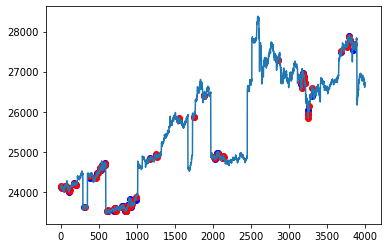

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np

gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size,1)
        self.softmax = nn.Softmax(dim=-1)
        
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input
        output = torch.unsqueeze(output, dim= 0)
        output = torch.unsqueeze(output, dim = -1)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        softmax = torch.sigmoid(fc)
        softmax = torch.squeeze(softmax, dim = 1)
        return softmax

class backtest:
  def start(self, close_p, model_wts,start,end,train_p, lin, lout):
    close = np.load(close_p)#
    train_p = np.load(train_p)
    train = torch.FloatTensor(train_p).to(gpu)
    model = SingleRNN(input_size=1,hidden_size = 5, dropout = 0, bidirectional= False).to(gpu)
    model.load_state_dict(torch.load(model_wts))#
    s , l, high = 0,0,0
    i = start
    lb, ls , sb, ss = [] , [], [], []
    lbx ,lsx = [], []
    lopen, lclose, sopen, sclose = 0, 0, 0, 0
    for i in range(start, end + 1):
      target = model(train[i,20:,0])
      price = close[i]

      if target > lin and l == 0 and s == 0:
        lb.append(price)
        lbx.append(i - start)
        high = price
        cv = i
        l += 1
        lopen += 1
      if  l == 1 and s == 0:
        # if cv +2 == i:
        if  ((price - high)*100/high) < -0.03:
        # or target < lout
          ls.append(price)
          lsx.append(i - start)
          l += -1
          lclose += 1
      if l == 1 and s == 0:
        if (lbx[-1] + start) != i:
          if high < price:
            high = price
      # if target < sin and l == 0 and s == 0:
      #   sb.append(price)
      #   s += 1
      #   sopen += 1
      # if target > sout and l == 0 and s ==1 :
      #   ss.append(price)
      #   s += -1
      #   sclose += 1
    if lopen != lclose:
      lb = lb[0:-1]
      lbx = lbx[0:-1]
    # if sopen != sclose:
    #   sb = sb[0:-1]
    win , lose = [], []
    for i in range(len(lb)):
      t = ls[i] - lb[i] - lb[i]*0.0008
      per = t*100/ls[i]
      if per > 0:
        win.append(per)
      if per < 0 :
        lose.append(per)
    if len(win) > 0:
      print(sum(win)/len(win))
    if len(lose) > 0:
      print(sum(lose)/len(lose))
    print(len(win)/(len(win)+len(lose))) 
    lperform = sum(ls) - sum(lb) - sum(ls)*0.0008
    print(ls)
    print(lb)
    print(len(ls))
    print(len(lb))
    # sperform = sum(sb) - sum(ss) - sum(sb)*0.08
    print('lperform:')
    print(lperform)
    # print('sperform:' + sperform)
    plt.plot(lbx,lb,'bo')
    plt.plot(lsx,ls,'ro')
    close = close[start:end]
    plt.plot(close)
    plt.show()

#self, close_p, model_wts,start,end,train_p, lin, lout, sin, sout
close_p = '/content/drive/MyDrive/LSTM DATA/past_volume change/train_close.npy'
model_wts = '/content/drive/MyDrive/classifierLSTM.pt'
train_p = '/content/drive/MyDrive/LSTM DATA/past_volume change/train_lstm.npy'
bt = backtest()
bt.start(close_p = close_p , model_wts = model_wts, start =0, end =4000, train_p = train_p, lin = 0.5, lout = 0.3)


In [ ]:
global c
a = 1
c.append(a)